# Sweep $d$ and $k$

In [1]:
import diptest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm.auto import tqdm
from itertools import combinations, product

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../el_farol')

from sim_utils import InteractiveBar
from data_utils import Commonality
from config import PATHS

In [ ]:
# ks = [1, 3]
# ds = [2, 4]
# ks = [9, 12]
# ds = [12, 24]
ks = [1, 3, 6, 9, 12]
ds = [2, 4, 6, 12, 24]
df_list = []

num_rounds = 100
num_episodes = 1

df = InteractiveBar.run_sweep(
    memories=ds,
    predictors=ks,
    num_experiments=num_episodes,
    num_agents=[100],
    threshold=0.6,
    num_rounds=[num_rounds]
).reset_index()

Running memory sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Running predictor sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Running agent sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running round sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Running agent sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running round sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Running predictor sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Running agent sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running round sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Running agent sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running round sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Running experiments:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df.head(2)

,index,Memory,Num_predictors,Identifier,Round,Agent,Decision,Score,Policy,Prediction,Inaccuracy
0,0,12,9,0,0,0,1,1,7-cyclic,53,NaN
1,1,12,9,0,1,0,1,-1,2-cyclic,100,47.0


### Plot sweep Inaccuracy

In [ ]:
# This cell shows the inaccuracy sweep

fig, axes = plt.subplots(
    len(ds), len(ks), 
    figsize=(3*len(ks),3*len(ds)), 
    tight_layout=True,
    sharex=True, sharey=True
)

for k, d in product(ks, ds):
    df_to_plot = df[(df['Memory'] == d) & (df['Num_predictors'] == k)]
    idx_k = ks.index(k)
    idx_d = ds.index(d)
    sns.lineplot(x='Round', y='Inaccuracy', data=df_to_plot, ax=axes[idx_d, idx_k])
    axes[idx_d, idx_k].set_title(f'k={k} -- d={d}')
    axes[idx_d, idx_k].set_ylabel('Inaccuracy')

In [ ]:
file_name = PATHS['folder_figures_for_paper'] / 'sweep_inaccuracy.png'
fig.savefig(file_name, dpi=300, bbox_inches='tight')

### Plot sweep $\Delta m$

In [ ]:
# This cell shows the sweep with Delta m

fig, axes = plt.subplots(
    len(ds), len(ks), 
    figsize=(3*len(ks),3*len(ds)), 
    tight_layout=True,
    sharex=True, sharey=True
)

for k, d in product(ks, ds):
    df_to_plot = df[(df['Memory'] == d) & (df['Num_predictors'] == k)]
    df_to_plot['Prediction_lag'] = df_to_plot.groupby(['Identifier','Agent'])['Prediction'].transform('shift',1)
    df_to_plot['Attendance'] = df_to_plot.groupby(['Identifier','Round'])['Decision'].transform('sum')

    # Delta m
    df1A = df_to_plot.groupby('Round')['Prediction_lag'].value_counts().reset_index(name='Count')
    # df2AA = df1A.groupby('Round').apply(lambda x: delta_m(list(x['Prediction_lag']), list(x['Count']))).reset_index()
    df2AA = df1A.groupby('Round').apply(lambda x: IQR(x['Prediction_lag'].values)).reset_index()
    df2AA.columns = ['Round','Dif_modes']

    # Plot
    idx_k = ks.index(k)
    idx_d = ds.index(d)
    sns.lineplot(x='Round', y='Dif_modes', data=df2AA, ax=axes[idx_d, idx_k])
    axes[idx_d, idx_k].set_title(f'k={k} -- d={d}')
    # axes[idx_d, idx_k].set_ylabel('$\Delta$m')
    axes[idx_d, idx_k].set_ylabel('Inter quartile Range')

In [ ]:
file_name = PATHS['folder_figures_for_paper'] / 'sweep_delta_m.png'
fig.savefig(file_name, dpi=300, bbox_inches='tight')

### Test de bimodalidad

In [ ]:
N = 1000
hN = N // 2
x = np.empty(N, dtype=np.float64)
dist = 1.25
x[:hN] = np.random.normal(dist, 1.0, hN)
x[hN:] = np.random.normal(-dist, 1.0, hN)

# both the dip statistic and p-value
dip, pval = diptest.diptest(x)

ax = sns.histplot(x, kde=True)
ax.set_title(f'Dip Test Example --- distance = {2*dist} (p={pval:.3f})')

In [ ]:
N = 1000
hN = N // 2
x = np.empty(N, dtype=np.float64)
dist = 1.5
x[:hN] = np.random.normal(dist, 1.0, hN)
x[hN:] = np.random.normal(-dist, 1.0, hN)

# both the dip statistic and p-value
dip, pval = diptest.diptest(x)

ax = sns.histplot(x, kde=True)
ax.set_title(f'Dip Test Example --- distance = {2*dist} (p={pval:.3f})')

In [ ]:
# generate some bimodal random draws
N = 1000
hN = N // 2
x = np.empty(N, dtype=np.float64)

df_dist = pd.DataFrame(columns=['Distance', 'Dip Statistic', 'p-value'])
distancias = [2, 1.5, 1.45, 1.4, 1.35, 1.3, 1.25, 1.1, 1, 0.5, 0.25]
# distancias = [1.5]
for dist in distancias:
    for i in range(100):
        x[:hN] = np.random.normal(dist, 1.0, hN)
        x[hN:] = np.random.normal(-dist, 1.0, hN)

        # both the dip statistic and p-value
        dip, pval = diptest.diptest(x)
        # Append the results to the DataFrame
        df_dist = df_dist.append({
            'Distance': 2*dist,
            'Dip Statistic': dip,
            'p-value': pval
        }, ignore_index=True)

ax = sns.lineplot(x='Distance', y='p-value', data=df_dist)
# draw a horizontal line at p=0.05
ax.axhline(y=0.05, color='r', linestyle='--', label='p=0.05')

In [ ]:
df_to_plot.head(2)

In [ ]:
dfB = df_to_plot.groupby('Identifier')['Decision'].mean().reset_index(name='Decision_mean')
dfB['Commonality'] = dfB.apply(lambda x: max(x['Decision_mean'], 1 - x['Decision_mean']), axis=1)
dfB.head(2)

In [ ]:
d = ds[0]
k = ks[0]
df_to_plot = df[(df['Memory'] == d) & (df['Num_predictors'] == k)]
n = df_to_plot['Identifier'].unique().tolist()[0]
dfA = df_to_plot[df_to_plot['Identifier'] == n].copy()
# dfA = dfA[(dfA['Round'] > 20) & (dfA['Round'] < 25)].reset_index(drop=True)

$$
\frac{\texttt{most\_frequent}}{N}
$$

In [ ]:
dfA

In [ ]:
dfA['Decision'].value_counts().max()

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(3, 12), tight_layout=True, sharex=True, sharey=True)

i = 0
for _, grp in dfA.groupby('Round'):
    sns.histplot(grp['Prediction'], kde=True, ax=ax[i], stat='density')    
    # dip, pval = diptest.diptest(grp['Prediction'])
    # delta = delta_m(grp['Prediction'], grp['Prediction'].value_counts().values)
    ax[i].set_title(f'p-value = {pval:.2f}')
    i += 1

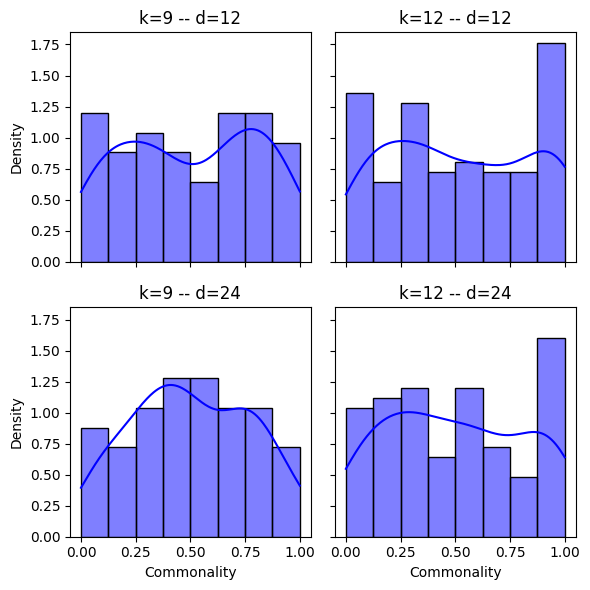

In [21]:
# This cell shows the sweep with the Sarle coefficient

fig, axes = plt.subplots(
    len(ds), len(ks), 
    figsize=(3*len(ks),3*len(ds)), 
    tight_layout=True,
    sharex=True, sharey=True
)

for k, d in product(ks, ds):
    df_to_plot = df[(df['Memory'] == d) & (df['Num_predictors'] == k)]
    df_to_plot['Prediction_lag'] = df_to_plot.groupby(['Identifier','Agent'])['Prediction'].transform('shift',1)
    df_to_plot['Attendance'] = df_to_plot.groupby(['Identifier','Round'])['Decision'].transform('sum')

    # # Sarle's bimodality coefficient:
    # df2A = df_to_plot.groupby('Round').agg(
    #     kurtosis=pd.NamedAgg(column="Prediction_lag", aggfunc=lambda x: x.kurt()),
    #     skewness=pd.NamedAgg(column="Prediction_lag", aggfunc=lambda x: x.skew()),
    #     count=pd.NamedAgg(column="Prediction_lag", aggfunc=lambda x: x.count()),
    # )
    # df2A['sarle'] = (df2A['skewness'] ** 2 + 1) / (df2A['kurtosis'] + (3 * (df2A['count'] - 1) ** 2) / ((df2A['count'] - 2) * (df2A['count'] - 3)))

    # #  Hartigan’s dip statistic
    # df2A = df_to_plot.groupby('Round').agg(
    #     hds=pd.NamedAgg(column="Prediction", aggfunc=lambda x: diptest.diptest(x)[0]),
    #     hds_pvalue=pd.NamedAgg(column="Prediction", aggfunc=lambda x: diptest.diptest(x)[1])
    # )

    df2A = df_to_plot.groupby('Round').agg(
        Commonality=pd.NamedAgg(column="Decision", aggfunc=lambda x: Commonality(x.values))
        # Commonality=pd.NamedAgg(column="Decision", aggfunc=lambda x: np.mean(x.values))
    )

    # Plot
    idx_k = ks.index(k)
    idx_d = ds.index(d)
    sns.histplot(df2A['Commonality'], kde=True, ax=axes[idx_d, idx_k], stat='density', color='blue')
    # sns.lineplot(x='Round', y='hds', data=df2A, ax=axes[idx_d, idx_k], color='blue', label='Dip Statistic')
    # sns.lineplot(x='Round', y='hds_pvalue', data=df2A, ax=axes[idx_d, idx_k], color='blue', label='Dip Statistic')
    # sns.lineplot(x='Round', y='sarle', data=df2A, ax=axes[idx_d, idx_k], color='blue', label='Dip Statistic')
    # sns.lineplot(x='Round', y='Commonality', data=df2A, ax=axes[idx_d, idx_k], color='red', label='p-value')
    axes[idx_d, idx_k].set_title(f'k={k} -- d={d}')
    # Dashed red line for 5/9 of Sarle's coefficient
    # axes[idx_d, idx_k].axhline(y=5/9, color='red', linestyle='--', label='5/9 Threshold')
    # if idx_d < len(ds) - 1:
    #     axes[idx_d, idx_k].legend_.remove()
    # else:
    #     if idx_k == len(ks) // 2:
    #         axes[idx_d, idx_k].legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    #     else:
    #         axes[idx_d, idx_k].legend_.remove()


In [ ]:
file_name = PATHS['folder_figures_for_paper'] / 'sweep_sarle.png'
fig.savefig(file_name, dpi=300, bbox_inches='tight')

---